# Learning Goals
This tutorial is a continuation of the [previous TESS NGC4151](https://github.com/tylerapritchard/TESSGI_Tut_NGC4151/blob/main/NGC4151.ipynb) notebook.  In this tutorial we will learn how to:
- Retrieve TESS mission Co-trending Basis Vectors and interpolate them for the FFI images
- Construct a TESS data model based on data from other sources
- Create a Design Matrix for de-trending TESS data from a variety of noise models
- De-trend the TESS light-curve 
- Add a model component to our de-trended lightcurve

# Introduction
From the [previous TESS NGC4151](https://github.com/tylerapritchard/TESSGI_Tut_NGC4151/blob/main/NGC4151.ipynb) notebook we found that our TESS background subtracted lightcurve had some long-timescale behavior that was similar to that seen from the ground.  
![TESS](TESS-ASAS.png)
In this notebook we will apply a series of more complicated lightcurve de-trending corrections, while also calculating a long-timescale flux model from the ground-based ASAS-SN data that we will use to both de-trend the observed TESS data and then re-apply it to recover the long-timescale variability.  


## First, let us recover our data from the previous notebook

In [55]:
%matplotlib inline
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from lightkurve import MPLSTYLE

import pandas as pd

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern

import pickle

In [57]:
# Read our lc and tpf from the previous notebook
lc=lk.read('NGC4151_lc_bkgsub.fits',quality_bitmask='none')
tpf=lk.read('NGC4151_tpf_bkgsub.fits',quality_bitmask='none')

# Recover our target mask and background mask from the previous notebook
target_mask, bigger_mask = pickle.load(open( "masks.p", "rb" ))

#Re-read the ASAS-SN ground-based g-band data
asas=pd.read_csv('ngc4151_asas.csv')
jdcut=(asas.HJD-2457000 > 2630) & (asas.HJD-2457000 < 2675)
asas=asas[jdcut]

Next, let us create a model of what our TESS lightcurve might look like on long-timescales.  To do this, **we will assume** that it has the same shape as the ASAS-SN normalized light-curve with a multiplicative factor.  To create this we will need a smooth interpolation of the ASAS-SN data with a normalized value at each point.  More complicated models are left to the user and their specific science needs.  

For our interpolation needs, we will use a gaussian process regressor with a RBF kernel and a white noise kernel (to capture the error behavior) of our points.  

In [39]:
# We want to do our regression with the asas-sn data, but predict on the tess epochs
def gpinterp(btjd,flux,tessjd):
    time=np.array(btjd).reshape(-1,1)
    val=np.array(flux)
    kernel =1.0*RBF(length_scale=2, length_scale_bounds=(0.5,1e2)) \
    + WhiteKernel(noise_level=1)
    
    gp=GaussianProcessRegressor(kernel=kernel, alpha=0.0)
    gp.fit(time, val)
    time_pred=tessjd.reshape(-1,1)
    val_pred,val_sigma = gp.predict(time_pred, return_std=True)
    return time_pred.reshape(-1), val_pred, val_sigma

Next, we fit this gaussian process regressor to the ASAS-SN g-band data, while interpolatingits values using the TESS lightcurve. 

In [40]:
# We're padding this a bit to avoid edge effects
sector_mask = (asas.HJD-2457000 > 2630) & (asas.HJD-2457000 < 2675)
gp_t, \
gp_f, \
gp_sig = gpinterp(asas.HJD-2457000, asas.flux/np.median(asas.flux),lc.time.value)

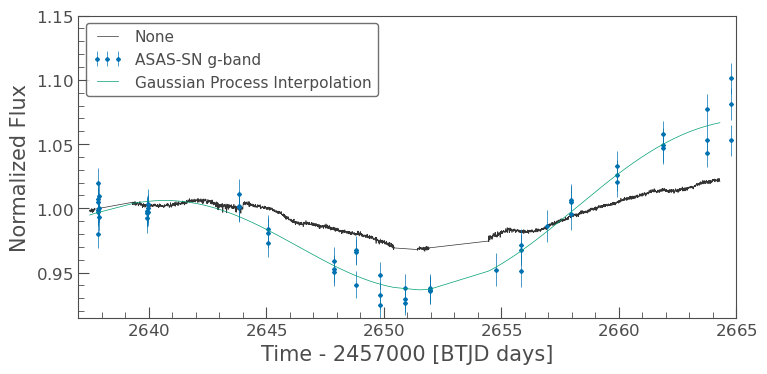

In [59]:
with plt.style.context(MPLSTYLE):  
    fig, ax = plt.subplots()
    lc.plot(ax=ax,normalize=True)
    ax.errorbar(asas.HJD-2457000,asas.flux/np.median(asas.flux),yerr=asas.flux_err/np.median(asas.flux),
                fmt='D',label='ASAS-SN g-band')
    ax.errorbar(gp_t,gp_f,label='Gaussian Process Interpolation')
    ax.set_ylim(0.915,1.15)
    ax.set_xlim(2637,2665)
    ax.legend(loc=2)

In [42]:
# Obtain the CBVs from the mission
# interpolate from 2min cbvs
ncbvs = 3

cbvc = lk.CBVCorrector(lc, interpolate_cbvs=True)
multiscale1 = cbvc.cbvs[1].interpolate(lc).to_pandas()
multiscale2 = cbvc.cbvs[2].interpolate(lc).to_pandas()
cbvs = np.hstack([np.asarray(multiscale2[multiscale2.columns[2:2+ncbvs]])])

In [43]:
#Estimate the pointing centroids from the TPF
row,col = tpf.estimate_centroids()

# These are cadences where there is non NaN flux inside the aperture.
k = np.isfinite(lc.flux) & np.isfinite(lc.flux_err)

# Design matrix with PCA of the pixels outside the aperture
dm1 = lk.DesignMatrix(np.nan_to_num(tpf.flux[k][:, ~bigger_mask]), name='bkg').pca(2)

# Design matrix with Cotrending Basis Vectors
dm2 = lk.DesignMatrix(cbvs[k], name='cbvs').split(list(np.where(np.diff(lc[k].cadenceno) > 100)[0] + 1))

# Design matrix with a gp model
dm3 = lk.DesignMatrix(gp_f[k], name='gp_model')

#centroid
dm5 = lk.DesignMatrix(np.nan_to_num(np.vstack([row.value, col.value, 
                                               row.value*col.value]).T)[k], 
                      name='centroids').split(list(np.where(np.diff(lc[k].cadenceno) > 100)[0] + 1))
# Combined Design Matrix
dm = lk.DesignMatrixCollection([dm1, dm2,dm3,dm5])

array([<AxesSubplot:ylabel='Flux'>,
       <AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>],
      dtype=object)

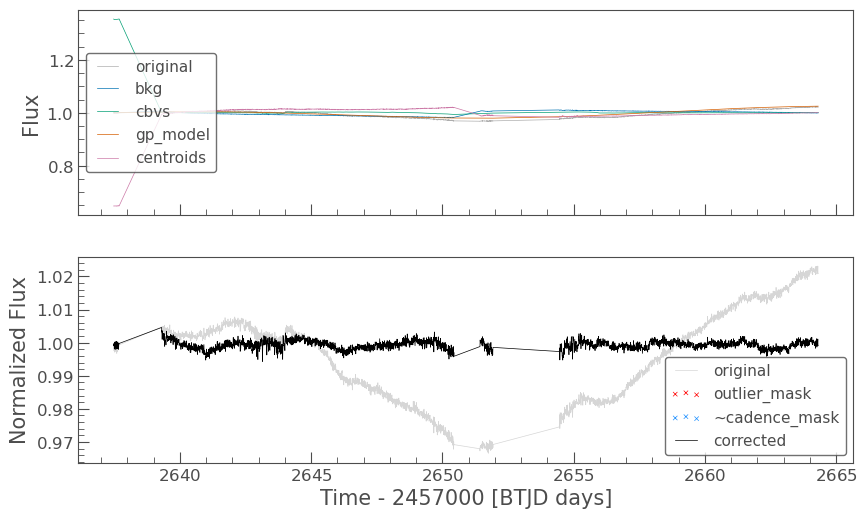

In [46]:
# Correct the light curve using combined design matrix
r = lk.RegressionCorrector(lc[k].normalize())
lc2 = r.correct(dm)

r.diagnose()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

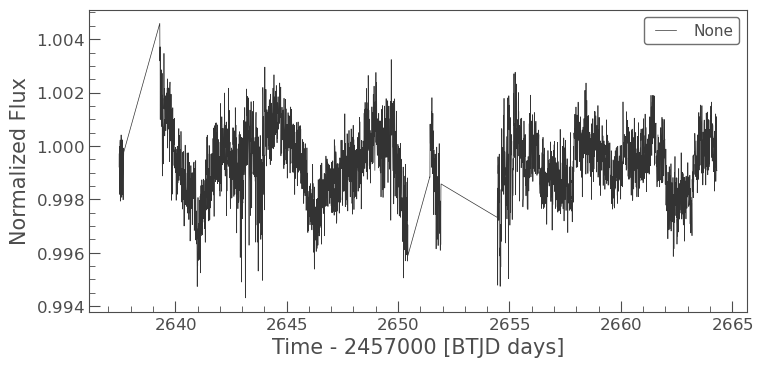

In [47]:
lc2.plot()

In [48]:
r.coefficients

array([-3.04447553e-02,  4.49420959e-01, -5.73813488e+02, -2.97770753e+02,
        2.68608285e+02,  2.60501316e-01, -3.16062144e-01, -5.27751294e-02,
        2.04809024e-02,  4.18423911e-02, -2.13467955e-01,  3.49529038e-01,
        2.04216146e-01,  9.66589753e-02, -2.51956917e-04,  4.19270924e-01,
       -2.06836437e-01, -1.58128320e-04,  1.58882849e-01, -1.34032183e-01,
       -1.03257916e-05])

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

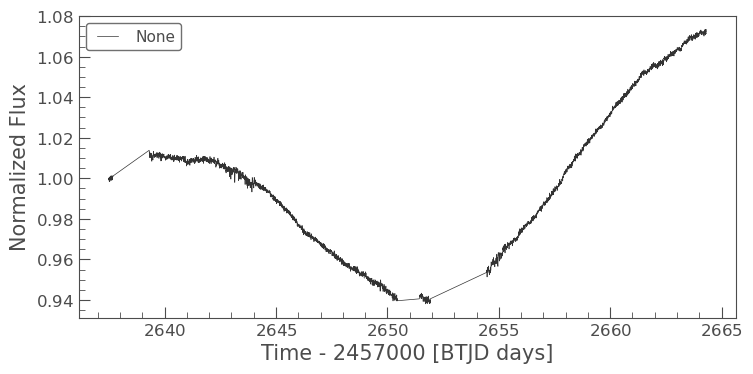

In [49]:
lc3=lc2
lc3.flux=lc2.flux*r.coefficients[11]*gp_f[k]
lc3.plot(normalize=True)

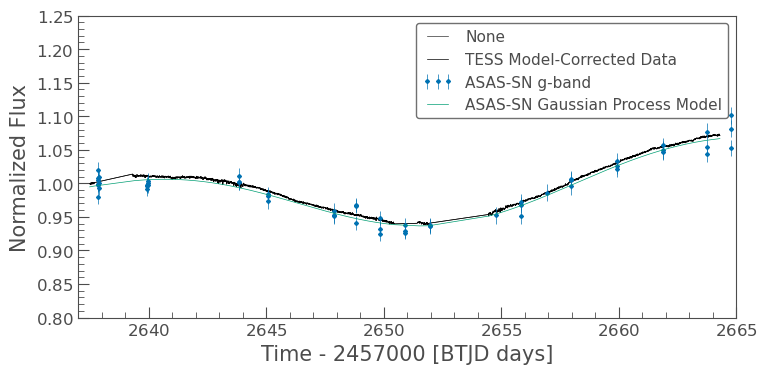

In [50]:
with plt.style.context(MPLSTYLE):  
    fig, ax = plt.subplots()
    lc3.plot(ax=ax,normalize=True)
    plt.plot(lc3.time.value,lc3.flux.value/np.nanmedian(lc3.flux.value),color='k',
             label='TESS Model-Corrected Data')
    ax.errorbar(asas.HJD-2457000,asas.flux/np.median(asas.flux),yerr=asas.flux_err/np.median(asas.flux),
                fmt='D',label='ASAS-SN g-band')
    ax.errorbar(gp_t,gp_f, label = 'ASAS-SN Gaussian Process Model')
    ax.set_ylim(0.8,1.25)
    ax.set_xlim(2637,2665)
    ax.legend()

/Users/tapritchard/anaconda3/envs/tessgi/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<AxesSubplot:xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power [$\\mathrm{\\frac{e^{-}}{s}}$]'>

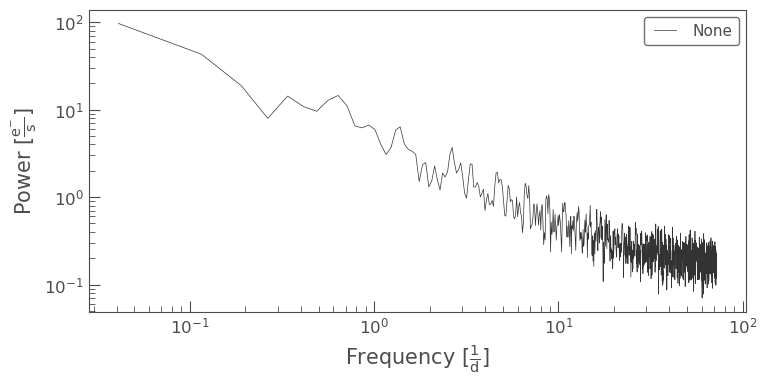

In [51]:
pd2=lc.to_periodogram(method='lombscargle')
pd2=pd2.bin()
pd2.plot(scale='log')